In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from scipy.stats import gaussian_kde
# from sklearn.decomposition import PCA

# from snmcseq_utils import plot_tsne_values
# from snmcseq_utils import plot_tsne_labels
# from snmcseq_utils import tsne_and_boxplot

In [11]:
# mch file
context = 'CH'
input_file = './data/binc/binc_mCH_human_combined_100000_summary.tsv'
df = pd.read_table(input_file, index_col=['chr', 'bin'], 
                       dtype={'chr': object})
print(df.shape)

(30353, 12870)


In [12]:
df.iloc[:5, :2]

160729_MB_v1_hs_25yr_MFG_pool_1000_AD008_indexed_mc  \
chr bin                                                           
1   0                                                       3     
    100000                                                  6     
    200000                                                  5     
    300000                                                  0     
    400000                                                  1     

            160729_MB_v1_hs_25yr_MFG_pool_1000_AD008_indexed_c  
chr bin                                                         
1   0                                                     123   
    100000                                                176   
    200000                                                 38   
    300000                                                  0   
    400000                                                 19

In [13]:
# metadata
meta_file = './data/metadata/metadata_human_combined_updated.tsv'
df_meta = pd.read_table(meta_file, index_col='Sample')
print(df_meta.shape)

(6435, 16)


In [14]:
df_mc = df.filter(regex='_mc$')
df_c = df.filter(regex='_c$')

df_c.columns = [col[:-len('_c')] for col in df_c.columns] 
df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns] 

print(df_mc.shape)
print(df_c.shape)

(30353, 6435)
(30353, 6435)


In [17]:
# Filter out bins with low and high coverage ...
# Keep only bins that have sufficient coverage in at least 99.5% of all cells


# low coverage
base_call_cutoff = 100 
sufficient_coverage_fraction = 0.995
condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 
# base_call_cutoff2 = 100 
# sufficient_coverage_fraction2 = 0.96
# condition2 = (df_c > base_call_cutoff2).sum(axis=1) >= sufficient_coverage_fraction2*(df.shape[1])/2.0 

# high coverage
condition2 = df_c.mean(axis=1) < 4000


condition = (condition1 & condition2) 

print("Matrix size before pruning... "+ str(df.shape))
df_f = df.loc[condition]
print("Matrix size after pruning... "+ str(df_f.shape))

# get mcc matrix with kept bins and nan values for low coverage sites
# df_c_nan = df_c.copy()
# df_c_nan[df_c < base_call_cutoff] = np.nan
# df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]



Matrix size before pruning... (30353, 12870)
Matrix size after pruning... (7236, 12870)


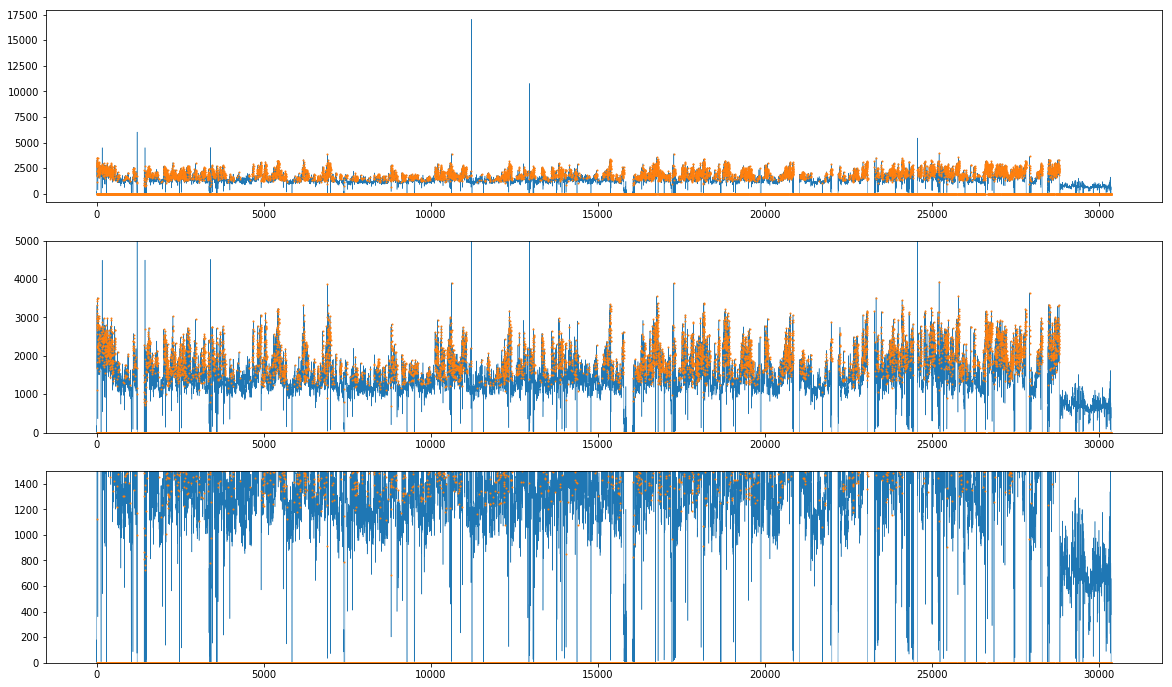

In [19]:
# evaluate the filtering process (what're kept)
baseline = df_c.mean(axis=1)
exp = condition.values*baseline.values
fig, axs = plt.subplots(3, 1, figsize=(20,12))
ax = axs[0]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax = axs[1]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax.set_ylim([0, 5000])
ax = axs[2]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax.set_ylim([0, 1500])
# plt.savefig('./results/pre')
plt.show()


In [8]:
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included

scf = np.arange(0.95, 1, 0.005)
res_list = []
base_call_cutoff = 100 
for sufficient_coverage_fraction in scf:
    # low coverage
    condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 
    # high coverage
    condition2 = df_c.mean(axis=1) < 4000
    # summarized condition
    condition = (condition1 & condition2) 
    # fraction of bins included
    res = np.sum(condition.values*1)/condition.shape[0]
    res_list.append(res)



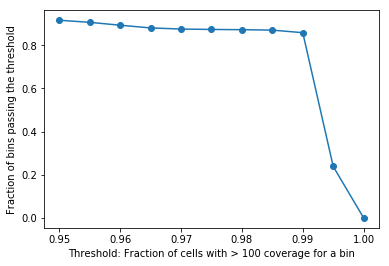

In [21]:
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included

fig, ax = plt.subplots()
ax.plot(scf, res_list, '-o')
ax.set_xlabel('Threshold: Fraction of cells with > 100 coverage for a bin')
ax.set_ylabel('Fraction of bins passing the threshold')
plt.show()

In [117]:
# choose a condition to move forward

# low coverage
base_call_cutoff = 100 
sufficient_coverage_fraction = 0.99
condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

# high coverage
condition2 = df_c.mean(axis=1) < 4000

condition = (condition1 & condition2) 

print("Matrix size before pruning... "+ str(df.shape))
df_f = df.loc[condition]
print("Matrix size after pruning... "+ str(df_f.shape))

# get mcc matrix with kept bins and nan values for low coverage sites
df_c_nan = df_c.copy()
df_c_nan[df_c < base_call_cutoff] = np.nan
df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]


# normalization (normalized by global mcc)
print('Normalization...')
context = 'CH'
for idx, row in df_meta.iterrows():
    samp = idx 
    if context == 'CH':
        df_mcc[samp] = (df_mcc[samp] / (row['mCH/CH']+.01))
    elif context == 'CG':
        df_mcc[samp] = (df_mcc[samp] / (row['mCG/CG']+.01))
    else:
        raise ValueError('Wrong context: %s' % context)

# imputation (missing value -> mean value of all cells)
print('Imputing data...')
means = df_mcc.mean(axis=1)
fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
df_mcc.fillna(fill_value, inplace=True)

# add "_mcc" suffix
df_mcc.columns = df_mcc.columns.values + '_mcc'

Matrix size before pruning... (30353, 12870)
Matrix size after pruning... (26058, 12870)
Normalization...
Imputing data...


In [118]:
df_mcc.iloc[:5,:5]
output_file = './data/binc/binc_mCH_human_combined_100000_summary_nmcc_v2.tsv'

df_mcc.to_csv(output_file, sep='\t', na_rep='NA', header=True, index=True)

In [24]:
# mcg file
context = 'CG'
input_file = './data/binc/binc_mCG_human_combined_100000_summary.tsv'
df = pd.read_table(input_file, index_col=['chr', 'bin'], 
                       dtype={'chr': object})
print(df.shape)

# metadata
meta_file = './data/metadata/metadata_human_combined_updated.tsv'
df_meta = pd.read_table(meta_file, index_col='Sample')
print(df_meta.shape)

(30353, 12870)
(6435, 16)


In [25]:
df_mc = df.filter(regex='_mc$')
df_c = df.filter(regex='_c$')

df_c.columns = [col[:-len('_c')] for col in df_c.columns] 
df_mc.columns = [col[:-len('_mc')] for col in df_mc.columns] 

print(df_mc.shape)
print(df_c.shape)

(30353, 6435)
(30353, 6435)


In [135]:
# Filter out bins with low and high coverage ...
# Keep only bins that have sufficient coverage in at least 99.5% of all cells

# low coverage
base_call_cutoff = 20 
sufficient_coverage_fraction = 0.98
condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

# high coverage
condition2 = df_c.mean(axis=1) < 500

condition = (condition1 & condition2) 

print("Matrix size before pruning... "+ str(df.shape))
df_f = df.loc[condition]
print("Matrix size after pruning... "+ str(df_f.shape))

# get mcc matrix with kept bins and nan values for low coverage sites
# df_c_nan = df_c.copy()
# df_c_nan[df_c < base_call_cutoff] = np.nan
# df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]

Matrix size before pruning... (30353, 12870)
Matrix size after pruning... (7632, 12870)


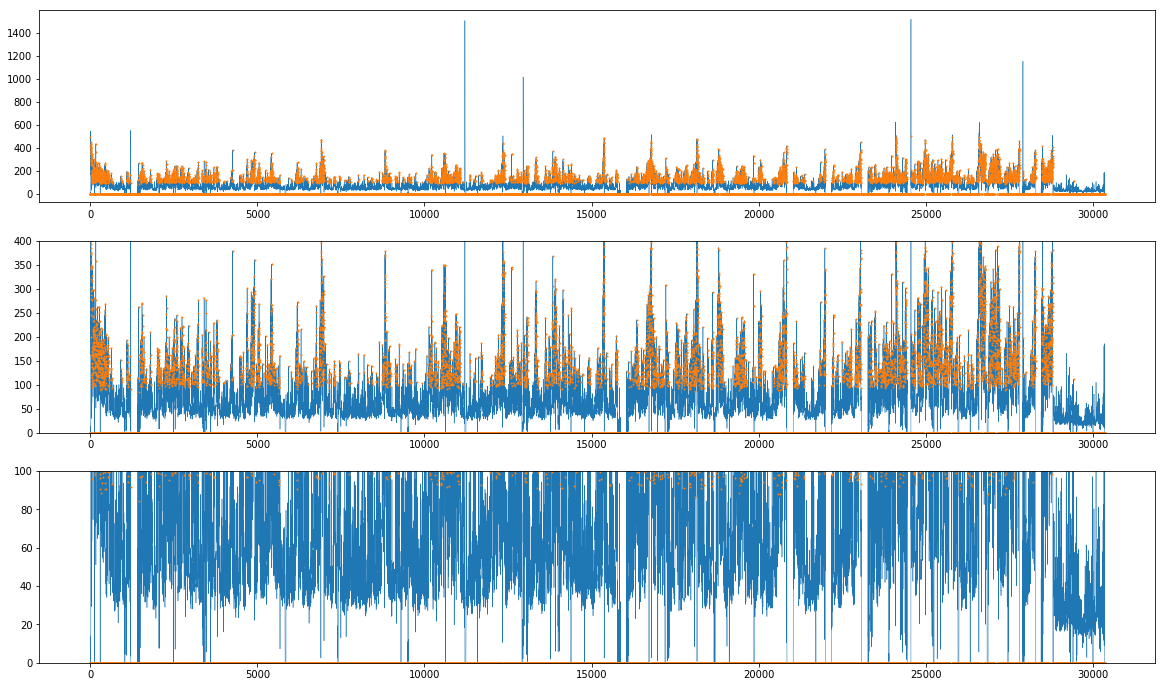

In [136]:
# evaluate the filtering process (what're kept)
baseline = df_c.mean(axis=1)
exp = condition.values*baseline.values
fig, axs = plt.subplots(3, 1, figsize=(20,12))
ax = axs[0]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax = axs[1]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax.set_ylim([0, 400])
ax = axs[2]
ax.plot(baseline.values, linewidth=0.5)
ax.plot(exp, 'o', markersize=1)
ax.set_ylim([0, 100])
# plt.savefig('./results/pre')
plt.show()


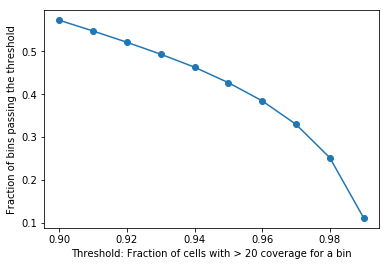

In [29]:
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included

scf = np.arange(0.9, 1, 0.01)
res_list = []
base_call_cutoff = 20 
for sufficient_coverage_fraction in scf:
    # low coverage
    condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 
    # high coverage
    condition2 = df_c.mean(axis=1) < 500
    # summarized condition
    condition = (condition1 & condition2) 
    # fraction of bins included
    res = np.sum(condition.values*1)/condition.shape[0]
    res_list.append(res)

    
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included
fig, ax = plt.subplots()
ax.plot(scf, res_list, '-o')
ax.set_xlabel('Threshold: Fraction of cells with > 20 coverage for a bin')
ax.set_ylabel('Fraction of bins passing the threshold')
plt.show()

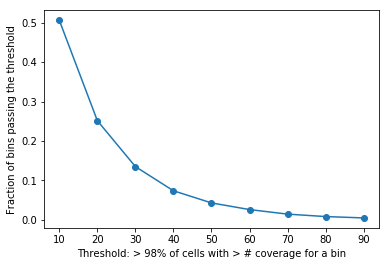

In [31]:
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included

sufficient_coverage_fraction = 0.98
res_list = []
bcf = np.arange(10, 100, 10) 
for base_call_cutoff in bcf:
    # low coverage
    condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 
    # high coverage
    condition2 = df_c.mean(axis=1) < 500
    # summarized condition
    condition = (condition1 & condition2) 
    # fraction of bins included
    res = np.sum(condition.values*1)/condition.shape[0]
    res_list.append(res)

    
# plot sufficient_fraction (fraction of cells) v.s. fractions of bins included
fig, ax = plt.subplots()
ax.plot(bcf, res_list, '-o')
ax.set_xlabel('Threshold: > 98% of cells with > # coverage for a bin')
ax.set_ylabel('Fraction of bins passing the threshold')
plt.show()

In [28]:
# choose a condition to move forward

# low coverage
base_call_cutoff = 20 
sufficient_coverage_fraction = 0.98
condition1 = (df_c > base_call_cutoff).sum(axis=1) >= sufficient_coverage_fraction*(df.shape[1])/2.0 

# high coverage
condition2 = df_c.mean(axis=1) < 500

condition = (condition1 & condition2) 

print("Matrix size before pruning... "+ str(df.shape))
df_f = df.loc[condition]
print("Matrix size after pruning... "+ str(df_f.shape))

# get mcc matrix with kept bins and nan values for low coverage sites
df_c_nan = df_c.copy()
df_c_nan[df_c < base_call_cutoff] = np.nan
df_mcc = df_mc.loc[condition]/df_c_nan.loc[condition]


# normalization (normalized by global mcc)
print('Normalization...')
context = 'CH'
for idx, row in df_meta.iterrows():
    samp = idx 
    if context == 'CH':
        df_mcc[samp] = (df_mcc[samp] / (row['mCH/CH']+.01))
    elif context == 'CG':
        df_mcc[samp] = (df_mcc[samp] / (row['mCG/CG']+.01))
    else:
        raise ValueError('Wrong context: %s' % context)

# imputation (missing value -> mean value of all cells)
print('Imputing data...')
means = df_mcc.mean(axis=1)
fill_value = pd.DataFrame({col: means for col in df_mcc.columns})
df_mcc.fillna(fill_value, inplace=True)

# add "_mcc" suffix
df_mcc.columns = df_mcc.columns.values + '_mcc'

Matrix size before pruning... (30353, 12870)
Matrix size after pruning... (7632, 12870)
Normalization...
Imputing data...


In [140]:
df_mcc.iloc[:5,:5]

output_file = './data/binc/binc_mCG_human_combined_100000_summary_nmcc_v2.tsv'
df_mcc.to_csv(output_file, sep='\t', na_rep='NA', header=True, index=True)

In [142]:
# concatenate mCH and mCG normalize each feature by its standard deviation

input_mch = './data/binc/binc_mCH_human_combined_100000_summary_nmcc_v2.tsv'
input_mcg = './data/binc/binc_mCG_human_combined_100000_summary_nmcc_v2.tsv'

df_mch = pd.read_table(input_mch, index_col=['chr', 'bin'], dtype={'chr': object})
df_mcg = pd.read_table(input_mcg, index_col=['chr', 'bin'], dtype={'chr': object})

print(df_mch.shape)
print(df_mcg.shape)

(26058, 6435)
(7632, 6435)


In [144]:
df_mchmcg = pd.concat([df_mch, df_mcg])
print(df_mchmcg.shape)

(33690, 6435)


In [148]:
df_mchmcg.iloc[-5:, :5]

160729_MB_v1_hs_25yr_MFG_pool_1000_AD008_indexed_mcc  \
chr bin                                                              
22  50800000                                          19.317948      
    50900000                                          11.962175      
    51000000                                          15.145596      
    51100000                                          16.594060      
X   61700000                                          15.303731      

              160729_MB_v1_hs_25yr_MFG_pool_1000_AD010_indexed_mcc  \
chr bin                                                              
22  50800000                                          15.108219      
    50900000                                           8.182067      
    51000000                                           7.698723      
    51100000                                           9.382819      
X   61700000                                          14.254303      

              160729_MB_v1_hs_25yr_MFG_pool_1001_AD008_indexed_mcc  \
chr bin                                                              
22  50800000                                          15.006057      
    50900000                                           8.664949      
    51000000                                          11.793899      
    51100000                                          12.774655      
X   61700000                                          14.653003      

              160729_MB_v1_hs_25yr_MFG_pool_1001_AD010_indexed_mcc  \
chr bin                                                              
22  50800000                                          15.038981      
    50900000                                           9.020070      
    51000000                                          13.088765      
    51100000                                           9.058057      
X   61700000                                          16.836684      

              160729_MB_v1_hs_25yr_MFG_pool_1002_AD010_indexed_mcc  
chr bin                                                             
22  50800000                                          16.844539     
    50900000                                          10.134900     
    51000000                                          15.030316     
    51100000                                          13.480046     
X   61700000                                          17.127229

In [153]:
# normalized by standard deviations of features
stds = df_mchmcg.apply(np.std, axis=1)
df_mchmcg_norm = df_mchmcg.divide(stds, axis=0)

In [154]:
output_file = './data/binc/binc_mCHmCG_human_combined_100000_summary_nmcc_v2.tsv'
df_mchmcg_norm.to_csv(output_file, sep='\t', na_rep='NA', header=True, index=True)